In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Gathering Data

### WeRateDogs Twitter archive

In [2]:
# load in the WeRateDogs Twitter archive into a pandas dataframe
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
# inspect first five rows of the dataset
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
# save dataset as a csv file
twitter_archive.to_csv('twitter_archive_enhanced.csv', encoding = 'utf-8', index = False)

### Dog breed predictions

In [4]:
import requests
from io import StringIO
# download file using provided link
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv', auth=('user', 'pass'))
# load the data into a pandas dataframe
image_predictions = pd.read_csv(StringIO(r.text), sep='\t')
# inspect first five rows of the dataset
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [5]:
# save dataset as a tsv file
image_predictions.to_csv('image_predictions.tsv', sep = '\t')

### Data from Twitter API

In [6]:
import json
df_list = []
# loop over each tweet to store information on tweed ID, retweed count, and favorite count
with open('tweet-json.txt', encoding='utf-8') as file:
    for tweet in file:
        # convert json string to a dictionary
        tweet_dict = json.loads(tweet)
        tweet_id = tweet_dict['id']
        retweet_count = tweet_dict['retweet_count']
        favorite_count = tweet_dict['favorite_count']
        df_list.append({'tweet_id': tweet_id, 'retweet_count': retweet_count, 'favorite_count': favorite_count})
# convert list to a pandas dataframe
tweets_api = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])
# inspect first five rows of the new dataset
tweets_api.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [7]:
# save dataset as a txt file
tweets_api.to_csv('tweet_json.txt', encoding = 'utf-8', index = False)


## Assessing Data

### i) Assessment of WeRateDogs Twitter Archive Data

In [8]:
# inspect data
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


There are several observations that can be made from the data. Firstly, there are columns for reply and retweet information which hints that the dataset might include replies and retweets in addition to original tweets. Secondly, there seems to be a lot of missing data in particularly in the reply, retweet, and dog stage columns. Also, the notation for missing data is not consistent across the dataset. In some columns missing values are denoted with 'NaN' and in other columns with 'None'. There seems to be errors in the dog name column (e.g., 'a'). There is redundant data (+0000) in the timestamp column. Source column has very messy data.

In [9]:
# inspect datatypes and check for missing data
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

Indeed, there seems to be a lot missing data especially in the in_reply_to_status_id, retweeted_status_id, and other reply and tweet columns. The datatype of these columns is float and not integer. There are about 60 tweets that are missing an url. Timestamp columns are not in datetime format. 

In [10]:
# summary statistics
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


The summary statistics for rating_numerator and rating_denominator show that there are some odd values in these columns. Most tweets have a denominator of 10 but there some extreme values in the data as the maximum denominator value is 170. Same observation can be made for the numerator. The maximum value for a numerator is 1,776.

In [11]:
# print out the first value in the source column
twitter_archive.source[0]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [12]:
# unique values in source column
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [13]:
#twitter_archive[twitter_archive['source'] == '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>']

A closer look into the source column shows that most of the posts are from Twitter. The data also includes posts from video sharing platform Vine.

Now, let's look at the *name* column and investigate any odd values.

In [14]:
# unique values in name column
twitter_archive.name.value_counts()

None       745
a           55
Charlie     12
Lucy        11
Oliver      11
          ... 
Dug          1
Ron          1
Zooey        1
Horace       1
Brownie      1
Name: name, Length: 957, dtype: int64

There seems to be a systematic error in the name data as the value 'a' repeats 55 times in the dataset. Let's investigate if there are any other errors in the same column by looking at names that start with a lowercase character.

In [15]:
# create a mask for names starting with a lowercase character
lower_mask = twitter_archive.name.str[0].str.islower()
# unique names starting with a lowercase character
twitter_archive.name[lower_mask].value_counts()

a               55
the              8
an               7
very             5
one              4
just             4
quite            4
mad              2
not              2
actually         2
getting          2
old              1
unacceptable     1
my               1
light            1
this             1
infuriating      1
all              1
such             1
incredibly       1
his              1
space            1
by               1
life             1
officially       1
Name: name, dtype: int64

While the value 'a' is the most common error, there are also other errors in the name column.

Now, let's look at the dog stage columns.

In [16]:
# unique values in doggo column
twitter_archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [17]:
# unique values in floofer column
twitter_archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [18]:
# unique values in pupper column
twitter_archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [19]:
# unique values in puppo column
twitter_archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

Each of the dog stage column can get only two values: value indicating the dog stage or missing value. There seems to be a lot of missing data in these columns.

Next, let's check if there are any duplicate rows in the data.

In [20]:
# number of duplicate rows
sum(twitter_archive.duplicated())

0

In [21]:
# number of duplicate rows based on tweet id
sum(twitter_archive.tweet_id.duplicated())

0

There does not seem to be any fully identical rows or rows with the same tweet id. Next, let's check duplicates using the tweet url.

In [22]:
# number of duplicate rows based on expanded tweet url
sum(twitter_archive.expanded_urls.duplicated())

137

There 137 duplicate tweets in the data. Let's now look at the duplicate rows.

In [23]:
# print out duplicate rows
twitter_archive[twitter_archive['expanded_urls'].duplicated() == True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
75,878281511006478336,NaN,NaN,2017-06-23 16:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Shadow. In an attempt to reach maximum zo...,NaN,NaN,NaN,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
76,878057613040115712,NaN,NaN,2017-06-23 01:10:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Emmy. She was adopted today. Massive r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
98,873213775632977920,NaN,NaN,2017-06-09 16:22:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sierra. She's one precious pupper. Abs...,NaN,NaN,NaN,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2286,667182792070062081,NaN,NaN,2015-11-19 03:29:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Timison. He just told an awful joke bu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667182792...,10,10,Timison,None,None,None,None
2293,667152164079423490,NaN,NaN,2015-11-19 01:27:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pipsy. He is a fluffball. Enjoys trave...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667152164...,12,10,Pipsy,None,None,None,None
2294,667138269671505920,NaN,NaN,2015-11-19 00:32:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Extremely intelligent dog here. Has learned to...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
2298,667070482143944705,6.670655e+17,4.196984e+09,2015-11-18 20:02:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After much debate this dog is being upgraded t...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None


In [24]:
# unique values in expanded_urls column if the row is a duplicate
twitter_archive[twitter_archive['expanded_urls'].duplicated() == True].expanded_urls.value_counts()

https://twitter.com/dog_rates/status/700747788515020802/photo/1                                                                                                                                                                                                                                              1
https://twitter.com/dog_rates/status/833124694597443584/photo/1,https://twitter.com/dog_rates/status/833124694597443584/photo/1,https://twitter.com/dog_rates/status/833124694597443584/photo/1                                                                                                              1
https://www.gofundme.com/lolas-life-saving-surgery-funds,https://twitter.com/dog_rates/status/835264098648616962/photo/1,https://twitter.com/dog_rates/status/835264098648616962/photo/1                                                                                                                     1
http://www.gofundme.com/bluethewhitehusky,https://twitter.com/dog_rates/status/831650051525

In [25]:
# unique values in expanded_urls column
twitter_archive.expanded_urls.value_counts()

https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1                                        2
https://twitter.com/dog_rates/status/816450570814898180/photo/1,https://twitter.com/dog_rates/status/816450570814898180/photo/1                                                                                                                                                                        2
https://www.gofundme.com/helpquinny,https://twitter.com/dog_rates/status/863062471531167744/photo/1,https://twitter.com/dog_rates/status/863062471531167744/photo/1,https://twitter.com/dog_rates/status/863062471531167744/photo/1,https://twitter.com/dog_rates/status/863062471531167744/photo/1    2
https://twitter.com/dog_rates/status/841077006473256960/photo/1                                              

The expanded urls column contains urls from websites outside Twitter, for example links to GoFundMe pages. Some tweets also have the same tweet url multiple times listed in the column.

In [26]:
# example of duplicate rows
duplicate_url_1 = twitter_archive.expanded_urls.value_counts().index[0]
twitter_archive[twitter_archive['expanded_urls'] == duplicate_url_1]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None


There are retweets in the data which explains why some tweets have the same expanded urls.

In [27]:
# rows that have values in retweeted_status_id column
twitter_archive.query('retweeted_status_id.notnull()', engine = 'python')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


Based on the text column, it seems that retweets can be identified using the retweeted_status_id column.

In [28]:
# rows that have values in in_reply_to_status_id column
twitter_archive.query('in_reply_to_status_id.notnull()', engine = 'python')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After 22 minutes of careful deliberation this ...,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
2149,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After countless hours of research and hundreds...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
2169,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tessa. She is also very pleased after ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669353438...,10,10,Tessa,None,None,None,None
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 good shit Bubka\n@wane15,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


Same applies to replies. In_reply_to_status_id can be used to identify replies from the dataset.

Next, let's investigate odd values in rating_numerator and rating_denominator columns.

In [29]:
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
0         2
15        2
75        2
420       2
182       1
204       1
143       1
121       1
99        1
20        1
45        1
27        1
17        1
24        1
26        1
44        1
50        1
60        1
80        1
84        1
88        1
1776      1
960       1
666       1
144       1
165       1
Name: rating_numerator, dtype: int64

Most values in rating_numerator seem reasonable. However, there are several extreme values (e.g., 1,776, 420, 204) which may be errors. 

In [30]:
# unique values in rating_denominator column
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
0         1
120       1
7         1
170       1
150       1
130       1
90        1
110       1
2         1
70        1
40        1
16        1
15        1
Name: rating_denominator, dtype: int64

The dog rating should be out of 10. However, there are still denominators that are less or greater than 10. Let's investigate rows that have a denominator greater than 10.

In [31]:
# print rows with a rating denominator greater than 10
twitter_archive.query('rating_denominator > 10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None


Some of the odd values in the rating columns are due to errors that happened when ratings were extracted from the text column. E.g., on row 342, the rating denominator is 15 because it's from a date. Also, some tweets have false ratings in the numerator column because the used extraction method did not take decimals into account.

### ii) Assessment of Image Predictions Data

In [32]:
# review dataset
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [33]:
# inspect datatypes and check for missing values
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [34]:
# summary statistics
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


The probabilities for each dog breed predictions are all within the limits of 0 and 1.

In [35]:
# create a sum of probability for each row
total_conf = image_predictions['p1_conf'] + image_predictions['p2_conf'] + image_predictions['p3_conf']

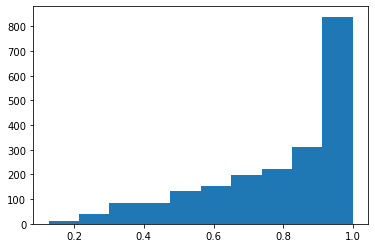

In [36]:
plt.hist(total_conf);

The sum of probabilities from the three predictions doesn't exceed 1 for any of the rows.

In [37]:
# number of duplicate rows
sum(image_predictions.duplicated())

0

No duplicate rows in the data.

In [38]:
# number of times the first prediction is a dog breed
image_predictions.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [39]:
# number of times the second prediction is a dog breed
image_predictions.p2_dog.value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [40]:
# number of times the thirds prediction is a dog breed
image_predictions.p3_dog.value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

In [41]:
# check rows where none of the predictions are a dog breed
image_predictions.query('p1_dog == False & p2_dog == False & p3_dog == False')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False


The jpg urls displayed on the first row shows that the animal in the image is a turtle, not a dog. This implies that not all tweets are dog tweets.

In [42]:
# check if all images are jpg files
image_predictions.jpg_url.str[-4:].value_counts()

.jpg    2073
.png       2
Name: jpg_url, dtype: int64

Most of the urls are linking to a jpg file but there two images that are in a png format.

### iii) Assessment of Data from Twitter API

In [43]:
# inspect dataset
tweets_api

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


In [44]:
# inspect datatypes and check for missing data
tweets_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [45]:
# summary statistics
tweets_api.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


In [46]:
# number of duplicate rows
sum(tweets_api.duplicated())

0

In [47]:
# number of duplicate rows based on tweet id
sum(tweets_api.tweet_id.duplicated())

0

**Quality issues**

*twitter_archive*
- There are retweets and replies in the dataset
- Missing values are not denoted consistently across the dataset. Some columns denote missing values as 'NaN' and others as 'None'
- Many rows have missing data on, e.g., dog name or dog stage. For example, only about 400 rows have dog stage information
- Some dog tweets have odd values in *name* column, such as 'a' or 'such'
- *timestamp* and *retweeted_status_timestamp* have redundant data (+0000)
- *source* contains messy data
- *in_reply_to_status_id*, *in_reply_to_user_id*, *retweeted_status_id*, and *retweeted_status_user_id* do not have the appropriate datatype
- *timestamp* and *retweeted_status_timestamp* are not in datetime format
- *rating_numerator* has odd values. For some tweets, rating has not been extracted correctly from the tweet text
- *rating_denominator* has odd values. The denominator is not always 10
- The data includes posts from Vine
- Some tweets have the same url listed multiple times in *expanded_urls* column
- Some tweets are missing an image

*image_predictions*

- The dataset contains images and predictions for tweets that are not dogs. Some of the dog breed predictions are not real dog breeds. E.g., 'paper_towel', 'orange', 'bagel', 'banana', or 'spatula'
- In dog breed predictions, space is replaced with an underscore '_'
- *jpg_url* column contains links to images that are in png format

**Tidiness issues**

*twitter_archive*

- Each dog stage has its own column
- *expanded_urls* column includes multiple urls

*All datasets*

- There are three different datasets, while one dataset would be sufficient

## Cleaning Data

In [48]:
# create a copy of the three datasets for cleaning and merging
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweets_api_clean = tweets_api.copy()

### Quality Issue #1

##### Define
There are retweets and replies in the dataset. Remove any replies or retweets. Also, drop columns *in_reply_to_status_id*, *in_reply_to_user_id*, *retweeted_status_id*, *retweeted_status_user_id*, and  *retweeted_status_timestamp* as they will contain only NaN values.

##### Code

In [49]:
# remove replies from the data
twitter_archive_clean.drop(index = twitter_archive_clean[twitter_archive_clean['in_reply_to_status_id'].notnull()].index, inplace = True)
# remove retweets from the data
twitter_archive_clean.drop(index = twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].notnull()].index, inplace = True)
# drop the selected columns
twitter_archive_clean.drop(columns = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], inplace = True)

##### Test

In [50]:
# check if replies, retweets, and related columns have been removed
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


### Quality Issue #2

##### Define
There are odd values in *name* column that start with a lowercase character. Change any dog name that starts with a lowercase character to NaN.

##### Code

In [51]:
# create a mask for names starting with a lowercase character
lower_mask_clean = twitter_archive_clean.name.str[0].str.islower()
# replace lowercase names with NaN values
twitter_archive_clean.name[lower_mask_clean] = np.nan

<ipython-input-51-9e8b18f4afc3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_archive_clean.name[lower_mask_clean] = np.nan


##### Test

In [52]:
# check that the mask include only NaN values
twitter_archive_clean.name[lower_mask_clean]

22      NaN
56      NaN
169     NaN
193     NaN
335     NaN
       ... 
2349    NaN
2350    NaN
2352    NaN
2353    NaN
2354    NaN
Name: name, Length: 104, dtype: object

In [53]:
# check that names starting with a lowercase do not appear in value counts
twitter_archive_clean.name.value_counts()

None       603
Lucy        11
Charlie     11
Oliver      10
Cooper      10
          ... 
Asher        1
Beebop       1
Chaz         1
Beemo        1
Sierra       1
Name: name, Length: 930, dtype: int64

### Quality Issue #3

##### Define
Unify the encoding for missing values in the dataset. Replace 'None' values with NaN.

##### Code

In [54]:
# change None values to NaN in the last five columns
twitter_archive_clean.iloc[:, -5:] = twitter_archive_clean.iloc[:, -5:].replace('None', np.nan)

##### Test

In [55]:
# check that None values have been converted to NaN
twitter_archive_clean.iloc[:, -5:]

,name,doggo,floofer,pupper,puppo
0,Phineas,NaN,NaN,NaN,NaN
1,Tilly,NaN,NaN,NaN,NaN
2,Archie,NaN,NaN,NaN,NaN
3,Darla,NaN,NaN,NaN,NaN
4,Franklin,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2351,NaN,NaN,NaN,NaN,NaN
2352,NaN,NaN,NaN,NaN,NaN
2353,NaN,NaN,NaN,NaN,NaN
2354,NaN,NaN,NaN,NaN,NaN


In [56]:
# check that None values have been converted to NaN
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                1390 non-null   object
 8   doggo               83 non-null     object
 9   floofer             10 non-null     object
 10  pupper              230 non-null    object
 11  puppo               24 non-null     object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


### Quality Issue #4

##### Define
Clean *timestamp* column by removing +0000 from the end of the string.

##### Code

In [57]:
twitter_archive_clean['timestamp'] = twitter_archive_clean['timestamp'].str[0:-6]

##### Test

In [58]:
twitter_archive_clean['timestamp'].str[0:-6]

0       2017-08-01 16
1       2017-08-01 00
2       2017-07-31 00
3       2017-07-30 15
4       2017-07-29 16
            ...      
2351    2015-11-16 00
2352    2015-11-16 00
2353    2015-11-15 23
2354    2015-11-15 23
2355    2015-11-15 22
Name: timestamp, Length: 2097, dtype: object

### Quality Issue #5

#### Define
Clean data in *source* column using regex.

#### Code

In [59]:
# extract source names from a longer string
twitter_archive_clean['source'] = twitter_archive_clean['source'].str.extract(r'>(.+)<')

#### Test

In [60]:
# check that all source names are clean
twitter_archive_clean.source.value_counts()

Twitter for iPhone     1964
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

### Quality Issue #6

##### Define
Convert values in *timestamp* column to datetime format.

##### Code

In [61]:
# convert timestamp to datetime format, include in data quality issues
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

##### Test

In [62]:
# check timestamp datatype after conversion
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2097 non-null   int64         
 1   timestamp           2097 non-null   datetime64[ns]
 2   source              2097 non-null   object        
 3   text                2097 non-null   object        
 4   expanded_urls       2094 non-null   object        
 5   rating_numerator    2097 non-null   int64         
 6   rating_denominator  2097 non-null   int64         
 7   name                1390 non-null   object        
 8   doggo               83 non-null     object        
 9   floofer             10 non-null     object        
 10  pupper              230 non-null    object        
 11  puppo               24 non-null     object        
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 213.0+ KB


### Quality Issue #7

#### Define
Extract ratings from tweet texts using regex to correct errors in the data. Remove any rows that do not have a rating (zero or missing) or have a rating above 15. Also, drop *rating_numerator* column.

#### Code

In [63]:
# extract dog ratings
twitter_archive_clean['dog_rating'] = twitter_archive_clean['text'].str.extract(r'(\d+\.?\d*)\/10[^\d]')
# convert rating from string to float
twitter_archive_clean['dog_rating'] = pd.to_numeric(twitter_archive_clean['dog_rating'], errors = 'coerce')
# drop rows with missing ratings
twitter_archive_clean = twitter_archive_clean.query('dog_rating > 0 & dog_rating <= 15')
# drop rating_denominator column
twitter_archive_clean.drop(columns = 'rating_numerator', inplace = True)

#### Test

In [64]:
# check that summary statistics are available for rating column
twitter_archive_clean.describe()

,tweet_id,rating_denominator,dog_rating
count,2.082000e+03,2082.000000,2082.000000
mean,7.366065e+17,10.021134,10.617570
std,6.719405e+16,0.920969,2.137451
min,6.660209e+17,2.000000,1.000000
25%,6.767853e+17,10.000000,10.000000
50%,7.097095e+17,10.000000,11.000000
75%,7.877873e+17,10.000000,12.000000
max,8.924206e+17,50.000000,14.000000


### Quality Issue #8

#### Define
Drop *rating_denominator* column. The new ratings that were extracted from tweet text all have 10 as the denominator.

#### Code

In [65]:
# drop rating_denominator column
twitter_archive_clean.drop(columns = 'rating_denominator', inplace = True)

#### Test

In [66]:
# check that the column has been removed
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2082 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tweet_id       2082 non-null   int64         
 1   timestamp      2082 non-null   datetime64[ns]
 2   source         2082 non-null   object        
 3   text           2082 non-null   object        
 4   expanded_urls  2079 non-null   object        
 5   name           1388 non-null   object        
 6   doggo          83 non-null     object        
 7   floofer        10 non-null     object        
 8   pupper         230 non-null    object        
 9   puppo          24 non-null     object        
 10  dog_rating     2082 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 195.2+ KB


### Quality Issue #9

#### Define
Drop observations that are from Vine platform.

#### Code

In [67]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['source'].str.contains('Vine') == False]

#### Test

In [68]:
twitter_archive_clean.source.value_counts()

Twitter for iPhone    1950
Twitter Web Client      31
TweetDeck               10
Name: source, dtype: int64

### Quality Issue #10

#### Define

Remove rows that have image predictations of which none is a dog breed.

##### Code

In [69]:
# remove rows with none of predictions are dog breeds
image_predictions_clean = image_predictions_clean.drop(image_predictions_clean[(image_predictions_clean['p1_dog'] == False) & (image_predictions_clean['p2_dog'] == False) & (image_predictions_clean['p3_dog'] == False)].index)

##### Test

In [70]:
# check that rows with a missing dog breed prediction have been removed
image_predictions_clean.query('p1_dog == False & p2_dog == False & p3_dog == False')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Quality Issue #11

##### Define
Replace underscores in dog breed predictions with space.

##### Code

In [71]:
# replace underscores in predictions with space
image_predictions_clean[['p1', 'p2', 'p3']] = image_predictions_clean[['p1', 'p2', 'p3']].replace('\_', ' ', regex=True)

##### Test

In [72]:
image_predictions_clean

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh springer spaniel,0.465074,True,collie,0.156665,True,Shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature pinscher,0.074192,True,Rhodesian ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake Bay retriever,0.425595,True,Irish terrier,0.116317,True,Indian elephant,0.076902,False
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English springer,0.225770,True,German short-haired pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper towel,0.170278,False,Labrador retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


### Quality Issue #12

##### Define
Rename jpg_url column to img_url.

##### Code & Test

In [73]:
# rename jpg_url column to image_url
image_predictions_clean = image_predictions_clean.rename(columns = {'jpg_url':'img_url'})

### Tidiness Issue #1

#### Define
Merge data from dog stage columns (*doggo*, *floofer*, *pupper*, and *puppo*) into one column. Drop the old dog stage columns.

#### Code

In [74]:
# merge dog stage columns into one column
twitter_archive_clean['dog_stage'] = twitter_archive_clean.doggo.fillna('') + ('/' + twitter_archive_clean.floofer).fillna('') + ('/' + twitter_archive_clean.pupper).fillna('') + ('/' + twitter_archive_clean.puppo).fillna('')
# create a mask for dog_stage
mask_dog_stage = twitter_archive_clean['dog_stage'].str.startswith("/")
# replace slash with empty string if value starts with a slash
twitter_archive_clean.dog_stage[mask_dog_stage] = twitter_archive_clean.dog_stage[mask_dog_stage].str.replace("/", "", n=1)
# replace empty strings with NaN
twitter_archive_clean['dog_stage'] = twitter_archive_clean['dog_stage'].replace("", np.nan)
# drop doggo, floofer, pupper, and puppo colums
twitter_archive_clean.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo'], inplace = True)

<ipython-input-74-baad5020fe1b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_archive_clean.dog_stage[mask_dog_stage] = twitter_archive_clean.dog_stage[mask_dog_stage].str.replace("/", "", n=1)


#### Test

In [75]:
# check dog stage values
twitter_archive_clean.dog_stage.value_counts()

pupper           205
doggo             66
puppo             22
doggo/pupper       8
floofer            7
doggo/floofer      1
doggo/puppo        1
Name: dog_stage, dtype: int64

In [76]:
# check that old dog stage columns have been removed
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tweet_id       1991 non-null   int64         
 1   timestamp      1991 non-null   datetime64[ns]
 2   source         1991 non-null   object        
 3   text           1991 non-null   object        
 4   expanded_urls  1988 non-null   object        
 5   name           1347 non-null   object        
 6   dog_rating     1991 non-null   float64       
 7   dog_stage      310 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 204.5+ KB


### Tidiness Issue #2

#### Define
Extract tweet url from *expanded_urls* column and create a new column *tweet_url*. Drop *expanded_urls* column and remove any rows with a missing tweet url.

#### Code

In [77]:
# extract tweet url from expanded_urls column
twitter_archive_clean['tweet_url'] = twitter_archive_clean['expanded_urls'].str.extract(r'(https\:\/\/twitter.com/dog_rates/status/[a-zA-Z0-9]+/photo/1)')
# drop expanded_urls column
twitter_archive_clean.drop(columns = 'expanded_urls', inplace = True)
# drop rows with a missing tweet url
twitter_archive_clean = twitter_archive_clean.drop(twitter_archive_clean[twitter_archive_clean['tweet_url'].isnull()].index)

#### Test

In [78]:
# inspect tweet urls
twitter_archive_clean.tweet_url

0       https://twitter.com/dog_rates/status/892420643...
1       https://twitter.com/dog_rates/status/892177421...
2       https://twitter.com/dog_rates/status/891815181...
3       https://twitter.com/dog_rates/status/891689557...
4       https://twitter.com/dog_rates/status/891327558...
                              ...                        
2351    https://twitter.com/dog_rates/status/666049248...
2352    https://twitter.com/dog_rates/status/666044226...
2353    https://twitter.com/dog_rates/status/666033412...
2354    https://twitter.com/dog_rates/status/666029285...
2355    https://twitter.com/dog_rates/status/666020888...
Name: tweet_url, Length: 1885, dtype: object

In [79]:
# first tweet url in the dataset
twitter_archive_clean.tweet_url[0]

'https://twitter.com/dog_rates/status/892420643555336193/photo/1'

In [80]:
# check that expanded_urls column has been dropped
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tweet_id    1885 non-null   int64         
 1   timestamp   1885 non-null   datetime64[ns]
 2   source      1885 non-null   object        
 3   text        1885 non-null   object        
 4   name        1315 non-null   object        
 5   dog_rating  1885 non-null   float64       
 6   dog_stage   284 non-null    object        
 7   tweet_url   1885 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 197.1+ KB


### Tidiness Issue #3

#### Define
Merge all three datasets into a one dataset. Drop rows with a missing tweet image url.

#### Code

In [81]:
# merge first twitter_archive_clean and image_predictions_clean
twitter_archive_master = pd.merge(twitter_archive_clean, image_predictions_clean, on = ['tweet_id', 'tweet_id'], how = 'inner')

#### Test

In [82]:
# inspect rows of the merged dataset
twitter_archive_master.head()

,tweet_id,timestamp,source,text,name,dog_rating,dog_stage,tweet_url,img_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,Tilly,13.0,NaN,https://twitter.com/dog_rates/status/892177421...,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
1,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,Archie,12.0,NaN,https://twitter.com/dog_rates/status/891815181...,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,Darla,13.0,NaN,https://twitter.com/dog_rates/status/891689557...,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper towel,0.170278,False,Labrador retriever,0.168086,True,spatula,0.040836,False
3,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,Franklin,12.0,NaN,https://twitter.com/dog_rates/status/891327558...,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English springer,0.225770,True,German short-haired pointer,0.175219,True
4,891087950875897856,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,NaN,13.0,NaN,https://twitter.com/dog_rates/status/891087950...,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake Bay retriever,0.425595,True,Irish terrier,0.116317,True,Indian elephant,0.076902,False


In [83]:
# inspect columns and dataset size
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1601 entries, 0 to 1600
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tweet_id    1601 non-null   int64         
 1   timestamp   1601 non-null   datetime64[ns]
 2   source      1601 non-null   object        
 3   text        1601 non-null   object        
 4   name        1158 non-null   object        
 5   dog_rating  1601 non-null   float64       
 6   dog_stage   241 non-null    object        
 7   tweet_url   1601 non-null   object        
 8   img_url     1601 non-null   object        
 9   img_num     1601 non-null   int64         
 10  p1          1601 non-null   object        
 11  p1_conf     1601 non-null   float64       
 12  p1_dog      1601 non-null   bool          
 13  p2          1601 non-null   object        
 14  p2_conf     1601 non-null   float64       
 15  p2_dog      1601 non-null   bool          
 16  p3          1601 non-nul

#### Code

In [84]:
# merge the new master dataset with tweets_api_clean
twitter_archive_master = pd.merge(twitter_archive_master, tweets_api_clean, on = ['tweet_id', 'tweet_id'], how = 'left')

#### Test

In [85]:
# inspect rows
twitter_archive_master.head()

,tweet_id,timestamp,source,text,name,dog_rating,dog_stage,tweet_url,img_url,img_num,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,Tilly,13.0,NaN,https://twitter.com/dog_rates/status/892177421...,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819
1,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,Archie,12.0,NaN,https://twitter.com/dog_rates/status/891815181...,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4328,25461
2,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,Darla,13.0,NaN,https://twitter.com/dog_rates/status/891689557...,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,...,0.170278,False,Labrador retriever,0.168086,True,spatula,0.040836,False,8964,42908
3,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,Franklin,12.0,NaN,https://twitter.com/dog_rates/status/891327558...,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,...,0.555712,True,English springer,0.225770,True,German short-haired pointer,0.175219,True,9774,41048
4,891087950875897856,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,NaN,13.0,NaN,https://twitter.com/dog_rates/status/891087950...,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,...,0.425595,True,Irish terrier,0.116317,True,Indian elephant,0.076902,False,3261,20562


In [86]:
# inspect columns and dataset size
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1601 entries, 0 to 1600
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tweet_id        1601 non-null   int64         
 1   timestamp       1601 non-null   datetime64[ns]
 2   source          1601 non-null   object        
 3   text            1601 non-null   object        
 4   name            1158 non-null   object        
 5   dog_rating      1601 non-null   float64       
 6   dog_stage       241 non-null    object        
 7   tweet_url       1601 non-null   object        
 8   img_url         1601 non-null   object        
 9   img_num         1601 non-null   int64         
 10  p1              1601 non-null   object        
 11  p1_conf         1601 non-null   float64       
 12  p1_dog          1601 non-null   bool          
 13  p2              1601 non-null   object        
 14  p2_conf         1601 non-null   float64       
 15  p2_d

## Storing, Analyzing, and Visualizing Data

In [87]:
# store master dataset into a csv file
twitter_archive_master.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index = False)
# load in the master dataset into a pandas dataframe
df_master = pd.read_csv('twitter_archive_master.csv')
# inspect dataset
df_master.head()

,tweet_id,timestamp,source,text,name,dog_rating,dog_stage,tweet_url,img_url,img_num,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,Tilly,13.0,NaN,https://twitter.com/dog_rates/status/892177421...,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819
1,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,Archie,12.0,NaN,https://twitter.com/dog_rates/status/891815181...,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4328,25461
2,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,Darla,13.0,NaN,https://twitter.com/dog_rates/status/891689557...,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,...,0.170278,False,Labrador retriever,0.168086,True,spatula,0.040836,False,8964,42908
3,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,Franklin,12.0,NaN,https://twitter.com/dog_rates/status/891327558...,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,...,0.555712,True,English springer,0.225770,True,German short-haired pointer,0.175219,True,9774,41048
4,891087950875897856,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,NaN,13.0,NaN,https://twitter.com/dog_rates/status/891087950...,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,...,0.425595,True,Irish terrier,0.116317,True,Indian elephant,0.076902,False,3261,20562


In [88]:
# subsample of tweets with a dog breed prediction as a first prediction
df_master_dogs = df_master.query('p1_dog == True')

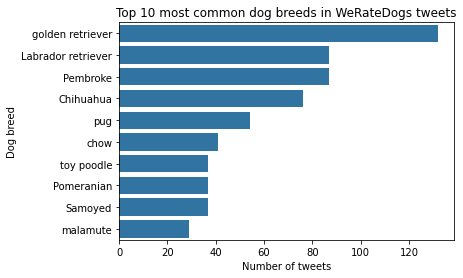

In [89]:
# import seaborn library
import seaborn as sb
# set blue as a base color
base_color = sb.color_palette()[0]
# horizontal bar chart of the top 10 most tweeted dog breeds
sb.countplot(data = df_master_dogs, y = 'p1', color = base_color, order = df_master_dogs.p1.value_counts().iloc[:10].index)
plt.title('Top 10 most common dog breeds in WeRateDogs tweets')
plt.xlabel('Number of tweets')
plt.ylabel('Dog breed');

In [90]:
# value counts by dog breed
df_master_dogs.p1.value_counts()

golden retriever           132
Labrador retriever          87
Pembroke                    87
Chihuahua                   76
pug                         54
                          ... 
wire-haired fox terrier      1
groenendael                  1
EntleBucher                  1
standard schnauzer           1
Japanese spaniel             1
Name: p1, Length: 111, dtype: int64

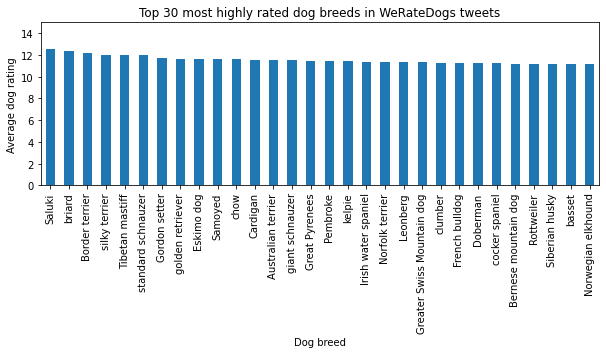

In [91]:
# vertical bar chart of the top 30 most highly rated dog breeds
df_master_dogs.groupby('p1')['dog_rating'].mean().sort_values(ascending = False).nlargest(30).plot(kind = 'bar', figsize = (10,3))
plt.title('Top 30 most highly rated dog breeds in WeRateDogs tweets')
plt.xlabel('Dog breed')
plt.ylabel('Average dog rating')
plt.ylim(0, 15);

In [92]:
# top 30 dog breeds by average dog rating
df_master_dogs.groupby('p1')['dog_rating'].mean().sort_values(ascending = False).head(30)

p1
Saluki                        12.500000
briard                        12.333333
Border terrier                12.142857
silky terrier                 12.000000
Tibetan mastiff               12.000000
standard schnauzer            12.000000
Gordon setter                 11.750000
golden retriever              11.632576
Eskimo dog                    11.625000
Samoyed                       11.621622
chow                          11.609756
Cardigan                      11.529412
Australian terrier            11.500000
giant schnauzer               11.500000
Great Pyrenees                11.416667
Pembroke                      11.413793
kelpie                        11.400000
Irish water spaniel           11.333333
Norfolk terrier               11.333333
Leonberg                      11.333333
Greater Swiss Mountain dog    11.333333
clumber                       11.270000
French bulldog                11.269231
Doberman                      11.250000
cocker spaniel                11.2400

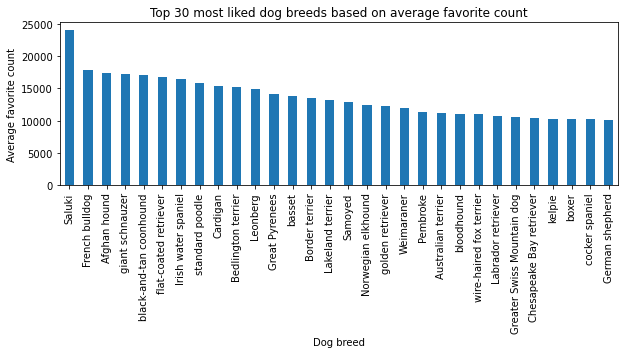

In [93]:
# vertical bar chart of the top 30 most liked dog breeds based on favorite count
df_master_dogs.groupby('p1')['favorite_count'].mean().sort_values(ascending = False).nlargest(30).plot(kind = 'bar', figsize = (10,3))
plt.title('Top 30 most liked dog breeds based on average favorite count')
plt.xlabel('Dog breed')
plt.ylabel('Average favorite count');

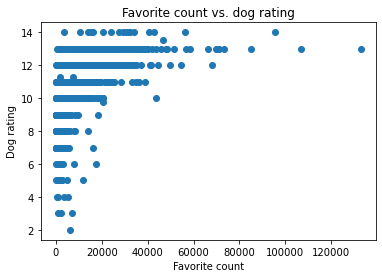

In [94]:
# scatterplot of favorite count and rating
plt.scatter(data = df_master_dogs, x = 'favorite_count', y = 'dog_rating')
plt.title('Favorite count vs. dog rating')
plt.xlabel('Favorite count')
plt.ylabel('Dog rating');

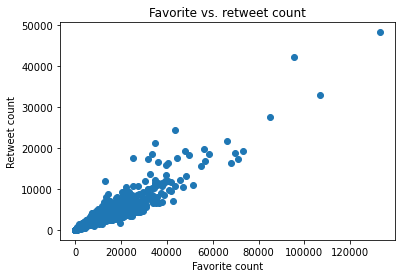

In [95]:
# scatterplot of favorite count and retweet count
plt.scatter(data = df_master_dogs, x = 'favorite_count', y = 'retweet_count')
plt.title('Favorite vs. retweet count')
plt.xlabel('Favorite count')
plt.ylabel('Retweet count');

## Sources

Package libraries and Udacity course materials


Stack Overflow: Pandas read json ValueError: Protocol not known
https://stackoverflow.com/questions/63553845/pandas-read-json-valueerror-protocol-not-known

Stack Overflow: How can I test if a string starts with a capital letter?
https://stackoverflow.com/questions/18974123/how-can-i-test-if-a-string-starts-with-a-capital-letter

Stack Overflow: Querying for NaN and other names in Pandas
https://stackoverflow.com/questions/26535563/querying-for-nan-and-other-names-in-pandas

Stack Overflow: Drop rows with specific string value pandas
https://stackoverflow.com/questions/60496119/drop-rows-with-specific-string-value-pandas

Stack Overflow: Replace None with NaN in pandas dataframe
https://stackoverflow.com/questions/23743460/replace-none-with-nan-in-pandas-dataframe

Stack Overflow: Drop rows on multiple conditions in pandas dataframe https://stackoverflow.com/questions/52456874/drop-rows-on-multiple-conditions-in-pandas-dataframe

Stack Overflow: How do I get a list of all the duplicate items using pandas in python?
https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python

Statology: Pandas: How to Drop Rows that Contain a Specific String
https://www.statology.org/pandas-drop-rows-that-contain-string/